<a href="https://colab.research.google.com/github/mpustil/DoctoradoPustilnik/blob/main/Modelos_SwiftV04_RF_pesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Modelo 04a: Imputacion + RF (sin SMOTE y con class_weight='balanced')  (1/12/2025)

# Fix (5/12/2025): Se arreglo la metrica (matriz de confusión)
# Fix (8/12/2025): identificar las SBS de la clasificacion

import pandas as pd
import numpy as np
import gc

'''
Archivos utilizados
Swift05_11SBS165.csv
https://drive.google.com/file/d/1T53fIqyrr70CHqXvB5lp0deJTxrfHUfV/view?usp=sharing
Swift05_11SBS52.csv
https://drive.google.com/file/d/1dQ5puACEkvwEE3zOl1vIrPglVQHXO7gD/view?usp=sharing

Swift11NoSBS.csv (solo registros sin flags de error)
https://drive.google.com/file/d/1-kSWbAy4ZL73eb6Wik3cei1s4iA1H1-j/view?usp=drive_link

'''
# To obtain a deterministic behaviour during subsampling and fitting, random_state has to be fixed to an integer
random_state = 41

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3(archivo, clase, archivo2 = ''):
  df = pd.read_csv(archivo, delimiter = ";")

  if archivo2 != '':
    df2 = pd.read_csv(archivo2, delimiter = ";")
    df = pd.concat([df,df2])
    del df2
    gc.collect()


  cols = ['2', '4']
  df[cols] = df[cols].applymap(np.int64)
  #variable target
  df['52'] = clase

  df.drop(['2', '112', '113', '114', '115'], axis=1, inplace=True)
  if clase == 1:
    #df.drop(['50','51','53'], axis=1, inplace=True)
    #Nos quedamos con el nombre
    df.drop(['50','51'], axis=1, inplace=True)
  else:
    df['53'] = ''

  # ponemos los NA
  listaVariables = ['110','111']
  df[listaVariables] = df[listaVariables].replace(0, np.nan)

  #que tenga al menos uno de los filtros
  df = df[(df['110'] >= 0) | (df['111'] >=0 ) ]
  if clase == 0:
  #que no tenga flags
     df = df[(df['20'] == 0) & (df['21'] ==0 ) ]
     df.drop(['20','21'], axis=1, inplace=True)

  return df


dfSBS = prepM3(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')

dfNoSBS = prepM3(ruta + 'Swift11NoSBS.csv', 0)


#print(len(dfNoSBS),len(dfSBS),len(df))

#del dfSBS
#del dfNoSBS
#gc.collect()

#imputacion lineal (en datos sin resumir)
from sklearn.linear_model import LinearRegression
import math

#y = ax+b  1 variable por ahora
def imputarLineal(x ,y, a, b):
    if math.isnan(y):
      ret = a*x+b
    else:
      ret = y
    return ret

#Imputacion por regresion lineal
def regresionLineal(df):
  # Dropping the entire rows with missing values
  df_drop = df.dropna()
  #print("total con 110 y 111 ",len(df_drop))
  #print(df_drop)

  # Fitting the linear regression model
  X = df_drop[['110']]
  y = df_drop['111']
  model110 = LinearRegression().fit(X, y)

  X = df_drop[['111']]
  y = df_drop['110']
  model111 = LinearRegression().fit(X, y)

  #print(f"Coefficients: {model110.coef_[0]}, Intercept: {model110.intercept_}")
  #print(f"Coefficients: {model111.coef_[0]}, Intercept: {model111.intercept_}")

  #print()
  #print(df.corr())
  df['111'] = df.apply(lambda x: imputarLineal(x['110'], x['111'], model110.coef_[0], model110.intercept_), axis=1)
  df['110'] = df.apply(lambda x: imputarLineal(x['111'], x['110'], model111.coef_[0], model111.intercept_), axis=1)

#imputacion por regresion lineal (en toda la base)
regresionLineal(dfSBS)
regresionLineal(dfNoSBS)

frames = [dfSBS, dfNoSBS]
df = pd.concat(frames)


/tmp/ipython-input-292275981.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)
/tmp/ipython-input-292275981.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)


In [ ]:
# Pre-procesamiento parte 2: submuestreo y sobremuestreo  (ya viene todo imputado!)

# importamos librerias para balancear los datos
from imblearn.under_sampling import RandomUnderSampler

#SMOTE (Synthetic Minority Over-sampling Technique)
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE


# vamos a dejar un 10% de SBS (sampling_strategy = 0.1) y 90% NoSBS, para luego, hacer oversamplig de SBS...
undersample = RandomUnderSampler(random_state=random_state, sampling_strategy = 0.1)

#oversample = SMOTE(random_state=random_state)

# Separamos en X e y
X_SBS = df.drop(['52'], axis=1)
y_SBS = df['52']

#hacemos el submuestreo
X_over_SBS, y_over_SBS = undersample.fit_resample(X_SBS , y_SBS)


# ahora hacemos el oversampling de las SBS
#X_over_SBS, y_over_SBS = oversample.fit_resample(X_over_SBS, y_over_SBS)

# preparamos todo para agrupar despues
df = X_over_SBS
df['52'] = y_over_SBS
dfSBS2 = df[(df['52'] == 1)]
dfNoSBS2 = df[(df['52'] == 0)]
dfSBS2.drop(['52'], axis=1,inplace= True)
dfNoSBS2.drop(['52'], axis=1,inplace= True)

print(len(dfSBS2), len(dfNoSBS2), len(X_over_SBS), len(df))


189 1890 2079 2079


/tmp/ipython-input-444168940.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSBS2.drop(['52'], axis=1,inplace= True)
/tmp/ipython-input-444168940.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNoSBS2.drop(['52'], axis=1,inplace= True)


In [ ]:
# Agrupador prepM3b  (y submuestreo del modelo agrupado)

def desvio0(min, max, desvio)->float:
  ret = float('nan')
  if not math.isnan(min):
    ret = desvio
    if min == max:
      ret = 0.0
  return ret



#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3b(df, clase):

  #2: obsid, 4: fuente   mantenemos la fuente, para poder hacer el ranking
#   df = df.groupby(['4'],group_keys=True).agg(
  df = df.groupby(['4'],group_keys=True).agg(
      #count=('2','count'),  # cant obs

      SBS=('53', 'min'),
      min110=('110', 'min'),
      max110=('110', 'max'),
      mean110=('110', 'mean'),
      std110=('110', 'std'),

      min111=('111', 'min'),
      max111=('111', 'max'),
      mean111=('111', 'mean'),
      std111=('111', 'std'))

  #corregimos el desvio muestral (cuando hay 1 sola muestra)
  df['std110'] = df.apply(lambda x: desvio0(x['min110'],x['max110'],x['std110']), axis=1)
  df['std111'] = df.apply(lambda x: desvio0(x['min111'],x['max111'],x['std111']), axis=1)

  #variable target
  df['52'] = clase

  return df

dfSBS2 = prepM3b(dfSBS2,1)
dfNoSBS2 = prepM3b(dfNoSBS2,0)

print(len(dfNoSBS2),len(dfSBS2))


frames = [dfSBS2, dfNoSBS2]
df = pd.concat(frames)
# Separamos en X e y. Quitamos 'SBS'
X_SBS = df.drop(['52','SBS'], axis=1)
y_SBS = df['52']


#NoSBS:1885 SBS:48
print(len(X_SBS))


1885 48
1933


In [ ]:
#------------------------------------------------ Entrenamiento y metricas (para cualquier modelo RF)}
# Sin SMOTE con class_weight='balanced' (Experimiento 3b)  el 3a (con pesos normales) se elimino

from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

sns.set(context='notebook')

# 30% para test y 70% para train
X_train_SBS, X_test_SBS, y_train_SBS, y_test_SBS = train_test_split(X_SBS,y_SBS, test_size=0.30,random_state=random_state)

# Definir el clasificador y los valores de los hiperparámetros a probar

def RF(_class_weight='balanced'):
  #clf = DecisionTreeClassifier(random_state=random_state, splitter='best')
  clf = RandomForestClassifier(random_state=random_state, class_weight= _class_weight)

  # controlo el sobreajuste con 'min_samples_leaf' : [3]
  #param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf' : [3]} #, 'min_samples_leaf' : [5]}

  #xxx se probo n_estimators 50,100,200 sin cambios significativos
  #pero ver despues del nuevo subsampleo

  param_grid = {'n_estimators':[10,20,30], 'criterion': ['gini', 'entropy'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf' : [3]} #, 'min_samples_leaf' : [5]}

  # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
  grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, return_train_score=True)
  grid_search.fit(X_train_SBS, y_train_SBS)

  return grid_search

# https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html
def BRF(_class_weight='balanced'):
  #clf = DecisionTreeClassifier(random_state=random_state, splitter='best')
  clf = BalancedRandomForestClassifier(random_state=random_state, class_weight= _class_weight)

  # controlo el sobreajuste con 'min_samples_leaf' : [3]
  #param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf' : [3]} #, 'min_samples_leaf' : [5]}

  #xxx se probo n_estimators 50,100,200 sin cambios significativos
  #pero ver despues del nuevo subsampleo

  param_grid = {'n_estimators':[10,20,30], 'criterion': ['gini', 'entropy'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf' : [3]} #, 'min_samples_leaf' : [5]}

  # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
  grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, return_train_score=True)
  grid_search.fit(X_train_SBS, y_train_SBS)

  return grid_search



In [ ]:
#Metricas y Graficamos matriz de confusion
from sklearn.metrics import accuracy_score

def imprimirMetricas(mcTexto, mcGrafico, redondeo, best_clf, soloF1, pesoSBS):

  cm = confusion_matrix(y_test_SBS,y_test_pred_SBS,labels=best_clf.classes_)
  TN, FP, FN, TP = cm.ravel()
  #  (con las clases 1,0)
  if mcGrafico:
    ConfusionMatrixDisplay(cm, display_labels=np.flip(best_clf.classes_)).plot()

  # Calculo de las predicciones en Train y test
  y_train_pred = best_clf.predict(X_train_SBS)
  y_test_pred = best_clf.predict(X_test_SBS)

  if not soloF1:
    print('El accuracy en train es:',round(accuracy_score(y_train_SBS,y_train_pred_SBS),redondeo))
    print('El accuracy en test es:', round(accuracy_score(y_test_SBS,y_test_pred_SBS),redondeo))

  #print(classification_report(y_test_SBS,y_test_pred_SBS))
  accu = (TP + TN) / (TP + FP + FN + TN)
  pres = TP / (TP + FP)
  rec = TP / (TP + FN)  # TP / (FN + TP)
  f1 = 2 * pres * rec / (pres + rec)

  if soloF1:
    print("pesoSBS", round(pesoSBS, redondeo), "F1", round(f1,redondeo))
  else:
    if mcTexto:
      print("Matriz de confusión")
      print("Predicho (1) (0)")
      print("Real(1) ",TP,"  ", FN)
      print("Real(0) ",FP,"  ", TN)

    print("Accuracy :  ", round(accu,redondeo))
    print("Precision : ", round(pres,redondeo))
    print("Recall :    ", round(rec,redondeo))
    print("F1 :        ", round(f1,redondeo))


pesoSBS = 0.80
while pesoSBS < 1.0:

  grid_search = RF({1:pesoSBS, 0: 1-pesoSBS})


  # Imprimir los resultados
  #print("Mejores hiperparámetros encontrados:")
  #print(grid_search.best_params_)
  #print("Mejor puntuación de validación cruzada:")
  #print(grid_search.best_score_)

  # Modelo decision tree con parametros optimizados
  best_clf = grid_search.best_estimator_

  # Predecimos Y
  y_train_pred_SBS = best_clf.predict(X_train_SBS)
  y_test_pred_SBS = best_clf.predict(X_test_SBS)

  imprimirMetricas(True, False, 4, best_clf, True, pesoSBS)
  pesoSBS =  pesoSBS + 0.02

El accuracy en train es: 0.9941
El accuracy en test es: 0.9914
Matriz de confusión
Predicho (1) (0)
Real(1)  16    4
Real(0)  1    559
Accuracy :   0.9914
Precision :  0.9412
Recall :     0.8
F1 :         0.8649


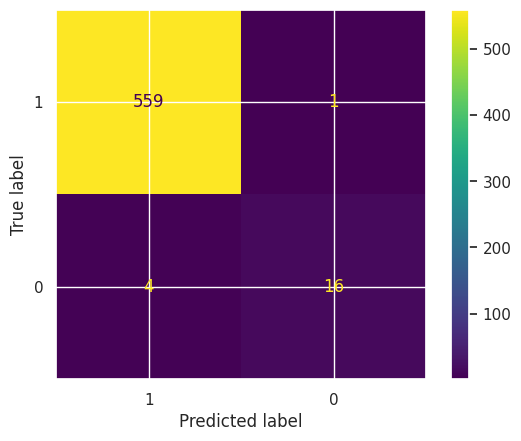

In [ ]:
  # class_weight='balanced'
  grid_search = RF()

  # Imprimir los resultados
  #print("Mejores hiperparámetros encontrados:")
  #print(grid_search.best_params_)
  #print("Mejor puntuación de validación cruzada:")
  #print(grid_search.best_score_)

  # Modelo decision tree con parametros optimizados
  best_clf = grid_search.best_estimator_

  # Predecimos Y
  y_train_pred_SBS = best_clf.predict(X_train_SBS)
  y_test_pred_SBS = best_clf.predict(X_test_SBS)

  imprimirMetricas(True, True, 4, best_clf, False, pesoSBS)

In [ ]:
    # class_weight='balanced'
grid_search = BRF()

  # Imprimir los resultados
  #print("Mejores hiperparámetros encontrados:")
  #print(grid_search.best_params_)
  #print("Mejor puntuación de validación cruzada:")
  #print(grid_search.best_score_)

  # Modelo decision tree con parametros optimizados
best_clf = grid_search.best_estimator_

  # Predecimos Y
y_train_pred_SBS = best_clf.predict(X_train_SBS)
y_test_pred_SBS = best_clf.predict(X_test_SBS)

imprimirMetricas(True, False, 4, best_clf, True, pesoSBS)

pesoSBS 1.0000000000000002 F1 0.1714


In [ ]:
#le agregamos los nombres de las SBS y la prediccion
X_test_SBS = X_test_SBS.merge(dfSBS2, how='left', on='4')

X_test_SBS.drop(['min110_y','min111_y','max110_y','max111_y','mean110_y','mean111_y','std110_y','std111_y'], axis=1, inplace=True)

X_test_SBS['pred'] = y_test_pred_SBS

soloSBS = X_test_SBS[X_test_SBS['SBS'].notna()]


In [ ]:
soloSBS.to_csv("SBSPredic.csv", sep=';', encoding='utf-8',index=False)

In [ ]:
dfSBS2.to_csv("SBSAgrupadas.csv", sep=';', encoding='utf-8',index=False)

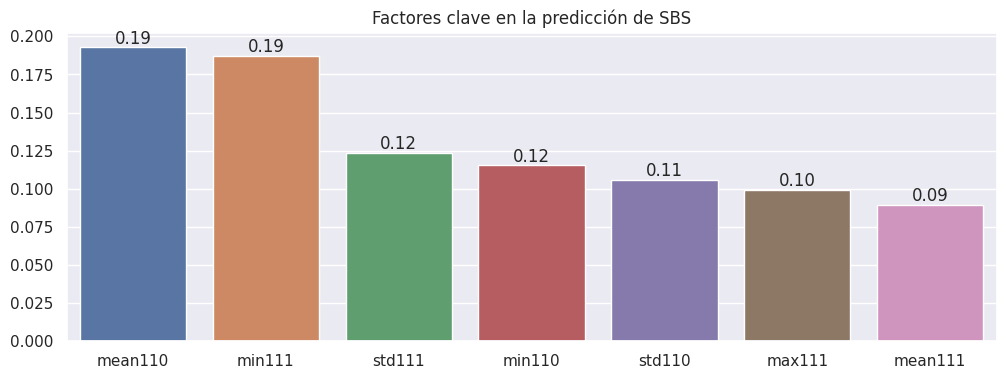

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=3,
                       n_estimators=30, random_state=41) instead.

<Figure size 1200x800 with 0 Axes>

In [ ]:
#importancia de atributos
#"112[2]:W1","113[3]:U","115[5]:V", "110[0]:W2","111[1]:M2""114[4]:B"

cantValMostrar = 7

feature_scores_SBS = pd.DataFrame(pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train_SBS.columns).sort_values(ascending=False).iloc[:cantValMostrar]).T

plt.figure(figsize=(12,4))
sns.barplot(data=feature_scores_SBS)

i = 0
for index, value in enumerate(feature_scores_SBS.values.flatten()):
    if i > cantValMostrar:
      break;
    i=i+1
    plt.annotate(f'{value:.2f}', xy=(index, value), ha='center', va='bottom')


plt.title("Factores clave en la predicción de SBS")
plt.show()

plt.figure(figsize = (12,8))

tree.plot_tree(grid_search.best_estimator_.fit(X_train_SBS, y_train_SBS));
tree.export_text(grid_search.best_estimator_.fit(X_train_SBS, y_train_SBS), feature_names=X_train_SBS.columns)



In [ ]:
#ojo, que guarda sin fuentes!
dfSBS.to_csv("Swift05_11SBS_Agrupado.csv", sep=';', encoding='utf-8',index=False)
dfNoSBS.to_csv("Swift05_11NoSBS_Agrupado.csv", sep=';', encoding='utf-8',index=False)